In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.1.0


In [2]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Root route
PATH = "DeepSpaceProject/DataSetDeepSpaceImages"

# Input data route 
INPATH = PATH + '/Input'
# Output data route
OUPATH = PATH + '/Target'
# Checkpoints Route
CKTPATH = PATH + '/Checkpoints'

imgurls = !ls -1 "{INPATH}"
print(imgurls)

n = 64
train_n = round(n * 0.80)

# Random list
randurls = np.copy(imgurls)

np.random.shuffle(randurls)

# Partition train/test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print("")
print(len(imgurls), len(tr_urls), len(ts_urls))
print("")
print(ts_urls)

['148678main_image_feature_573_ys_full.jpg', '299421main_lonerstarburst_20081120_HI_full.jpg', '35451843005_c37989a434_o.jpg', '360108main_hs-2009-10-a-xlarge_web_full.jpg', '377770main_spitzer20090723_full.jpg', '509679main_M33_full.jpg', '597502main_hs-2008-16-aa-xlarge_web_full.jpg', '611265main_hubble_holidaywreath_full.jpg', '628859main_hubble-eldorado_full_full.jpg', '659793main_CosmicCollision1-lg_full.jpg', '673032main_PIA15255_full.jpg', '729779main_hubble_spin_full_full.jpg', 'andromeda.jpg', 'archives_ngc6946.jpg', 'cena_0.jpg', 'eso137.jpg', 'frontier_macsj0416.jpg', 'hubble-lostinspace.jpg', 'hubble_friday_01082016.jpg', 'hubble_friday_01212016.jpg', 'hubble_friday_03112016.jpg', 'hubble_friday_03272015.jpg', 'hubble_friday_04012016.jpg', 'hubble_friday_05132016.jpg', 'hubble_friday_07152016.jpg', 'hubble_friday_10012015.jpg', 'hubble_friday_11062015.jpg', 'hubble_friday_11132015.jpg', 'hubble_monday_07252016.jpg', 'm101.jpg', 'm106.jpg', 'm51.jpg', 'm51_1.jpg', 'ngc1232.j

Executing op ReadFile in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DecodeJpeg in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ResizeBilinear in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Squeeze in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_random_jitter_103 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0


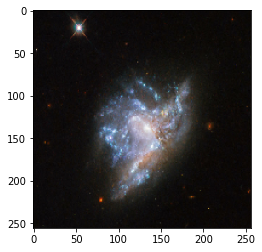

In [5]:
IMG_WIDTH = 256
IMG_HEIGHT = 256


def resize(inimg, tgimg, height, width):
    
    inimg = tf.image.resize(inimg, [height, width])
    tgimg = tf.image.resize(tgimg, [height, width])
    
    return inimg, tgimg


# Normalizes the image to rank [-1, +1] 
def normalize(inimg, tgimg):
    inimg = (inimg / 127.5) - 1
    tgimg = (tgimg / 127.5) - 1
    
    return inimg, tgimg


@tf.function()
# Augmentation of the data: Random Crop + Flip
def random_jitter(inimg, tgimg):
    
    inimg, tgimg = resize(inimg, tgimg, 286, 286)
    
    stacked_image = tf.stack([inimg, tgimg], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    inimg, tgimg = cropped_image[0], cropped_image[1]
    
    if tf.random.uniform(()) > 0.5:
        
        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)
        
    return inimg, tgimg


def load_image(filename, augment = True):
    
    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :3]
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)), tf.float32)[..., :3]
    
    inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
    
    if augment:
        inimg, tgimg = random_jitter(inimg, tgimg)
        
    inimg, tgimg = normalize(inimg, tgimg)
    
    return inimg, tgimg


def load_train_image(filename):
    return load_image(filename, True)

def load_test_image(filename):
    return load_image(filename, False)

plt.imshow(((load_train_image(randurls[0])[1]) + 1) / 2)

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


In [7]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):
    
    result = Sequential()
    
    initializer = tf.random_normal_initializer(0, 0.02)
    
    # Add Convolutional Layer
    result.add(Conv2D(filters, 
                        kernel_size=4,
                        strides=2,
                        padding="same",
                        kernel_initializer=initializer,
                        use_bias=not apply_batchnorm))
    
    if apply_batchnorm:
        # BatchNorm Layer
        result.add(BatchNormalization())
    
    # Activation Layer 
    result.add(LeakyReLU())
    
    return result

downsample(64)


In [8]:
def upsample(filters, apply_dropout=False):
    
    result = Sequential()
    
    initializer = tf.random_normal_initializer(0, 0.02)
    
    # Add Convolutional Layer
    result.add(Conv2DTranspose(filters, 
                                kernel_size=4,
                                strides=2,
                                padding="same",
                                kernel_initializer=initializer,
                                use_bias=False))
    
    # BatchNorm Layer
    result.add(BatchNormalization())
    
    if apply_dropout:
        # Dropout Layer 
        result.add(Dropout(0.5))
        
    # Activation Layer 
    result.add(ReLU())
    
    return result

upsample(64)


In [9]:
def Generator():
    
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    
    down_stack = [
        downsample(64, apply_batchnorm=False),      # (bs, 128, 128, 64)
        downsample(128),                            # (bs, 64, 64, 128)
        downsample(256),                            # (bs, 32, 32, 256)
        downsample(512),                            # (bs, 16, 16, 512)
        downsample(512),                            # (bs, 8, 8, 512)
        downsample(512),                            # (bs, 4, 4, 512)
        downsample(512),                            # (bs, 2, 2, 512)
        downsample(512),                            # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, apply_dropout=True),          # (bs, 2, 2, 1024)
        upsample(512, apply_dropout=True),          # (bs, 4, 4, 1024)
        upsample(512, apply_dropout=True),          # (bs, 8, 8, 1024)
        upsample(512),                              # (bs, 16, 16, 1024)
        upsample(256),                              # (bs, 32, 32, 512)
        upsample(128),                              # (bs, 64, 64, 256)
        upsample(64),                               # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0, 0.02)
    
    last = Conv2DTranspose(filters = 3,
                            kernel_size = 4,
                            strides = 2,
                            padding = "same",
                            kernel_initializer=initializer,
                            activation = "tanh")
    
    x = inputs
    s = []
    
    concat = Concatenate()
    
    for down in down_stack:
        x = down(x)
        s.append(x)
    
    s = reversed(s[:-1])
        
    for up, sk in zip(up_stack, s):
        x = up(x)
        x = concat([x, sk])
        
    last = last(x)
    
    return Model(inputs=inputs, outputs=last)

generator = Generator()


Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhos

In [10]:
def Discriminator():
    
    ini = Input(shape=[None, None, 3], name="input_img")
    gen = Input(shape=[None, None, 3], name="gener_img")
    
    con = concatenate([ini, gen])
    
    initializer = tf.random_normal_initializer(0, 0.02)
    
    down1 = downsample(64, apply_batchnorm=False)(con) # (bs, 128, 128, 64)
    down2 = downsample(128)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256)(down2) # (bs, 32, 32, 256)
    down4 = downsample(512)(down3)
    
    last = tf.keras.layers.Conv2D(filters=1,
                                     kernel_size=4,
                                     strides=1,
                                     kernel_initializer=initializer,
                                     padding="same")(down4)
    return tf.keras.Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator()

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0


In [11]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(disc_real_output, disc_generated_output):
    
    #Difference between the trues for being real and the detected by the discriminator
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    #Difference between the falses for being real and the detected by the discriminator
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [13]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss

In [14]:
import os

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(CKTPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



In [15]:
#checkpoint.restore(tf.train.latest_checkpoint(CKTPATH))

In [16]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
    
    prediction = model(test_input, training=True)
    
    if save_filename:
        tf.keras.preprocessing.image.save_img(PATH + '/output/' + save_filename + '.jpg', prediction[0, ...])

    plt.figure(figsize=(10,10))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    if display_imgs:
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
            
    plt.show()

In [17]:
@tf.function()
def train_step(input_image, target):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    
        output_image = generator(input_image, training=True)

        output_gen_discr = discriminator([output_image, input_image], training=True)

        output_trg_discr = discriminator([target, input_image], training=True)

        discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

        gen_loss = generator_loss(output_gen_discr, output_image, target)
    
        
        generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
        
        discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
        
        discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))
        

In [18]:
from IPython.display import clear_output
import datetime
import time

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        imgi = 0
        for input_image, target in dataset:
            print('epoch' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))
            imgi += 1
            train_step(input_image, target)
            clear_output(wait=True)
        
        imgi = 0
        for inp, tar in test_dataset.take(5):
            generate_images(generator, inp, tar, str(imgi)+'_'+str(epoch), display_imgs=True)
            imgi += 1
        
        # saving (checkpoint) the model every 50 epochs
        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

    checkpoint.save(file_prefix = checkpoint_prefix)

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


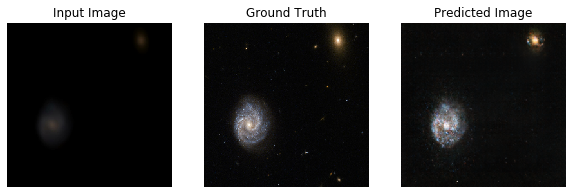

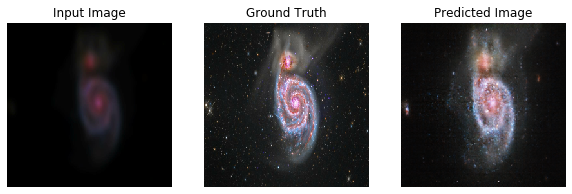

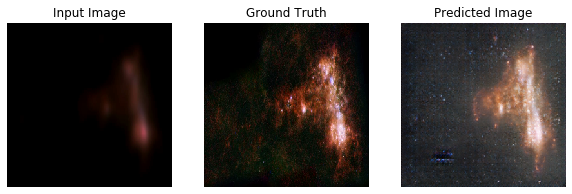

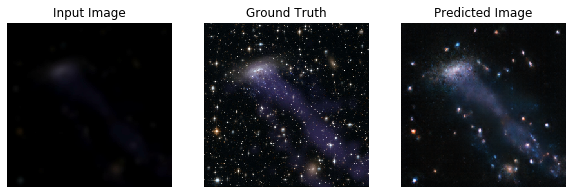

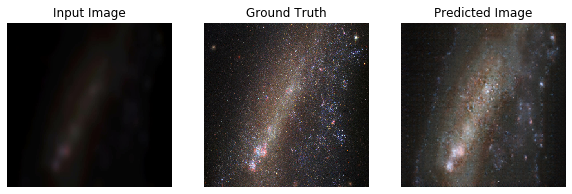

Time taken for epoch 500 is 58.926555156707764 sec



In [19]:
train(train_dataset, 500)